<a href="https://colab.research.google.com/github/ziga50/GEOINF2-seminarska/blob/main/RefugeeHeatExtract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

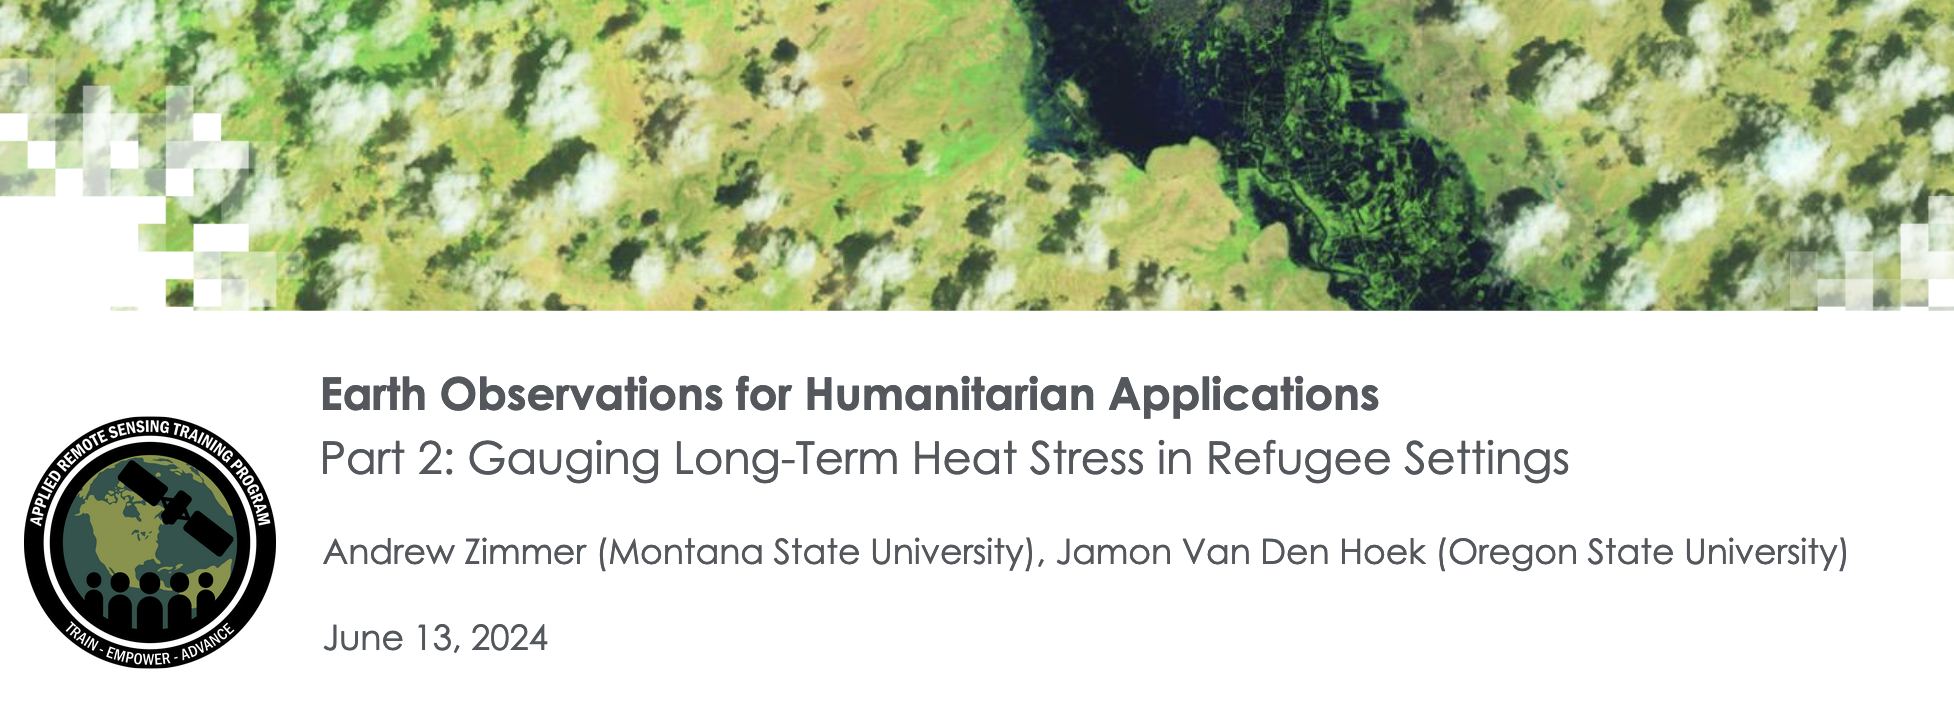

# **NASA ARSET Training 2024**
# **Part 2: Gauging Long-Term Heat Stress in Refugee Settings**

Here, we will walk through a script designed to evaluate heat metrics for refugee settings in Uganda and Kenya. This will read in, process and display era-5 heat data and extract hourly values for refugee settlements, before plotting


# Step 1 - Setup

Here we'll get everything ready to go, load packages and data, and start to explore geemap

In [ ]:
pip install cartopy

In [ ]:
# loading packages
import ee # allows us to access earth engine data
import geemap # allows us to interact with ee data using python, and map it!
import xarray as xr # allows for quick and scaleable processing of climate data
import geopandas as gpd # general geoprocessing packages
import pandas as pd # allows us to work with data frames
import numpy as np  # allows for calculations
from shapely.geometry import Point  # geoprocessing
from matplotlib import pyplot as plt  # plotting
import matplotlib.dates as mdates # useful for organizing dates
import os # miscellaneous operating system tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
# loading one more package, which allows us to access our own data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change my directory so I have access to my files and other packages
%cd '/content/drive/MyDrive/ColabNotebooks/heat-processing'

/content/drive/MyDrive/ColabNotebooks/heat-processing


In [ ]:
# loading the NEWT package - we'll use this later for calculating Tw
from atmos import moisture
from atmos import thermo

In [ ]:
#ee.Authenticate() # triggers the authentication process - you might have to set up a gee account to get this going. Don't need to run after you've authenticated
geemap.ee_initialize(opt_url="https://earthengine-highvolume.googleapis.com") # high volume makes things a bit easier/quicker

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=-zUg62zXWXhk3TSALtoAeAzOHR4kazMrEHDHmwAn1fg&tc=leQOWuDsuv_g55cWdZ5rheDRynLYjZwuQq4eeYkb0v4&cc=wNQ-2L332vlBymM9caEmde6pVAJjMX9sxOJhoTaHrIw

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdLIrYcTH6HTv9j4sbKGOvw1CcCcGQqa66CZCQwYjME5JfWGEkhddabzVSQ

Successfully saved authorization token.


In [ ]:
# create an interactive basemap using geemap
myMap = geemap.Map(center = [40, -100], zoom = 2)
myMap

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

# Step 2 - Accessing Climate Data

Here, we'll look at two ways to access climate data from earth engine, using ee and geemap to access them

In [ ]:
# we can access google earth engine data using ee
#loading some climate data - ERA5 Daily in this case - we will use hourly later
climateData = ee.ImageCollection('ECMWF/ERA5/DAILY')
climateData # loads as a collection of images

In [ ]:
# select desired bands (maximum_2m_air_temperature in our case)
temp = climateData.select("maximum_2m_air_temperature")
temp # still an image collection, because we have multiple observations

In [ ]:
# initial date of interest (inclusive)
i_date = '2018-01-01'

# final data of interest (exclusive)
f_date = '2019-01-01'

# select desired bands (maximum_2m_air_temperature), dates, and calculate max temperature across that date range
temp = climateData.select("maximum_2m_air_temperature").filterDate(i_date, f_date).max()
temp # now we have an image, rather than an image collection. You can examine it

In [ ]:
# these data use kelvin, so we'll need to convert it to celsius so we can interpret it a little easier
temp_celsius = temp.subtract(273.15)
temp_celsius

In [ ]:
# We're going to plot the maximum temperature in 2020. First we need to make a palette. This is from the GEE documentation
# https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY
# Visualization parameters for the range 17C to 47C (which corresponds to 290K to 320K)
vis2mt_celsius = {
    'min': 17,
    'max': 47,
    'palette': [
        '000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
        '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
        'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff'
    ]
}

In [ ]:
# Add the temperature layer in Celsius to the map
myMap.addLayer(temp_celsius, vis2mt_celsius, 'Maximum 2m Air Temperature (C)', opacity=0.3)

# Define the legend dictionary to match the new color palette for the range 17C to 47C
legend_dict_celsius = {
    'Below 17C': '000080',
    '17-19C': '0000d9',
    '19-21C': '4000ff',
    '21-23C': '8000ff',
    '23-25C': '0080ff',
    '25-27C': '00ffff',
    '27-29C': '00ff80',
    '29-31C': '80ff00',
    '31-33C': 'daff00',
    '33-35C': 'ffff00',
    '35-37C': 'fff500',
    '37-39C': 'ffda00',
    '39-41C': 'ffb000',
    '41-43C': 'ffa400',
    '43-45C': 'ff4f00',
    '45-47C': 'ff2500',
    'Above 47C': 'ff00ff'
}

# Add the legend to the map
myMap.add_legend(title='Max Daily Temperature (C)', legend_dict=legend_dict_celsius)

# Display the map
myMap

Map(bottom=8444.0, center=[1.0546279422758869, 36.91042544093864], controls=(WidgetControl(options=['position'…

In [ ]:
# We now have some idea of the extreme temperatures in a year. But what if we wanted to add in humidity?
# Wet bulb temperature does not exist natively in the era5 record, so we'll have to calculate it
# this will be done with hourly data, so we'll clip it down a bit to make it more manageable
# let us focus on Kenya and Uganda - since these countries host lots of refugee camps

In [ ]:
# we'll load the data using xarray this time to make the computation easier
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterDate(
    "2018-01-01", "2018-12-31"
)
ds = geemap.ee_to_xarray(dataset, crs="EPSG:4326", scale=0.1)
ds

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.0 MB/s eta 0:00:00


<xarray.Dataset>
Dimensions:                                                       (time: 8736,
                                                                   lon: 3600,
                                                                   lat: 1800)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [ ]:
# we only need a few of the variables, so let's select them
variables_to_keep = ['temperature_2m', 'dewpoint_temperature_2m', 'surface_pressure']

# Use the `.sel()` method with the `variables` argument
dsVars = ds.drop_vars(set(ds.data_vars) - set(variables_to_keep))
dsVars = dsVars.transpose('time', 'lat', 'lon')
dsVars

<xarray.Dataset>
Dimensions:                  (time: 8736, lon: 3600, lat: 1800)
Coordinates:
  * time                     (time) datetime64[ns] 2018-01-01 ... 2018-12-30T...
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.9 180.0
  * lat                      (lat) float64 -89.95 -89.85 -89.75 ... 89.85 89.95
Data variables:
    dewpoint_temperature_2m  (time, lat, lon) float32 ...
    temperature_2m           (time, lat, lon) float32 ...
    surface_pressure         (time, lat, lon) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [ ]:
# because we want to reduce computational load, we'll clip the data to kenya and uganda using a bounding box
uganda_kenya_bbox = {
    'lon': (29.5, 42.0),  # Extended longitude range to cover both Uganda and Kenya
    'lat': (-4.7, 4.6)    # Extended latitude range to cover both Uganda and Kenya
}

ds_uganda = dsVars.sel(lon=slice(uganda_kenya_bbox['lon'][0], uganda_kenya_bbox['lon'][1]),
                              lat=slice(uganda_kenya_bbox['lat'][0], uganda_kenya_bbox['lat'][1]))

ds_uganda

<xarray.Dataset>
Dimensions:                  (time: 8736, lat: 93, lon: 125)
Coordinates:
  * time                     (time) datetime64[ns] 2018-01-01 ... 2018-12-30T...
  * lon                      (lon) float64 29.55 29.65 29.75 ... 41.85 41.95
  * lat                      (lat) float64 -4.65 -4.55 -4.45 ... 4.35 4.45 4.55
Data variables:
    dewpoint_temperature_2m  (time, lat, lon) float32 ...
    temperature_2m           (time, lat, lon) float32 ...
    surface_pressure         (time, lat, lon) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [ ]:
# saving temp 2m for later
ds_temp2m = ds_uganda[['temperature_2m']]
ds_temp2m['temperature_2m'] = ds_temp2m['temperature_2m'] - 273.15
ds_temp2m # now we have the same lat/lon and only 365 time observations (i.e. the daily maximum)

<xarray.Dataset>
Dimensions:         (time: 8736, lat: 93, lon: 125)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-01 ... 2018-12-30T23:00:00
  * lon             (lon) float64 29.55 29.65 29.75 29.85 ... 41.75 41.85 41.95
  * lat             (lat) float64 -4.65 -4.55 -4.45 -4.35 ... 4.35 4.45 4.55
Data variables:
    temperature_2m  (time, lat, lon) float32 22.35 19.08 17.41 ... 26.59 28.06
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [ ]:
# now we calculate specific humidity from dewpoint temperature and surface pressure
# this might take a few minutes - it's running over 93 million calculations!
q = xr.apply_ufunc(moisture.specific_humidity_from_dewpoint_temperature, ds_uganda.surface_pressure, ds_uganda.dewpoint_temperature_2m).compute()
q = q.rename('q')
q

<xarray.DataArray 'q' (time: 8736, lat: 93, lon: 125)>
array([[[0.01438958, 0.01343867, 0.0136419 , ...,        nan,
                nan,        nan],
        [0.01454135, 0.01348749, 0.01335307, ...,        nan,
                nan,        nan],
        [0.01471698, 0.01366926, 0.01331857, ...,        nan,
                nan,        nan],
        ...,
        [0.00999228, 0.00963925, 0.00910845, ..., 0.00584538,
         0.00610151, 0.00611635],
        [0.00885942, 0.00855585, 0.00812254, ..., 0.0057521 ,
         0.00589539, 0.00599287],
        [0.00774348, 0.00749295, 0.00716033, ..., 0.00562969,
         0.00576782, 0.00591431]],

       [[0.01445817, 0.01347467, 0.01363948, ...,        nan,
                nan,        nan],
        [0.01454072, 0.01351882, 0.01354012, ...,        nan,
                nan,        nan],
        [0.01460781, 0.01369968, 0.0135496 , ...,        nan,
                nan,        nan],
...
        [0.01294869, 0.01303758, 0.01307234, ..., 0.01037121,
         0.01045392, 0.01036499],
        [0.01280369, 0.01284755, 0.01291502, ..., 0.01040834,
         0.01031138, 0.01028464],
        [0.0125697 , 0.01266791, 0.01281818, ..., 0.0103876 ,
         0.01026882, 0.01027509]],

       [[0.01565183, 0.0147532 , 0.01469132, ...,        nan,
                nan,        nan],
        [0.01610594, 0.01490494, 0.0142477 , ...,        nan,
                nan,        nan],
        [0.01662033, 0.015263  , 0.01421031, ...,        nan,
                nan,        nan],
        ...,
        [0.01290858, 0.01298085, 0.01302053, ..., 0.01031442,
         0.01039929, 0.01030824],
        [0.01275452, 0.01277562, 0.01282522, ..., 0.01038286,
         0.01027569, 0.01024525],
        [0.01252145, 0.01259198, 0.01270633, ..., 0.01038054,
         0.01027611, 0.01025649]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-30T23:00:00
  * lon      (lon) float64 29.55 29.65 29.75 29.85 ... 41.65 41.75 41.85 41.95
  * lat      (lat) float64 -4.65 -4.55 -4.45 -4.35 -4.25 ... 4.25 4.35 4.45 4.55

In [ ]:
# now we calculate wet bulb temperature using surface pressure, 2m temperature and humidity (that we just calculated)
# again, this might take a few minutes because we're doing lots of calculations
tw = xr.apply_ufunc(thermo.adiabatic_wet_bulb_temperature, ds_uganda.surface_pressure, ds_uganda.temperature_2m, q)
tw = tw - 273.15 # k to c
tw = tw.rename('tw')
tw

<xarray.DataArray 'tw' (time: 8736, lat: 93, lon: 125)>
array([[[19.41012608, 17.33259085, 16.87037099, ...,         nan,
                 nan,         nan],
        [19.73920241, 17.41391449, 16.27466242, ...,         nan,
                 nan,         nan],
        [20.09381059, 17.69988067, 16.22451164, ...,         nan,
                 nan,         nan],
        ...,
        [16.2456105 , 15.88461477, 15.41087854, ..., 12.64608074,
         13.36031607, 13.61394979],
        [15.26905318, 14.85630999, 14.43067291, ..., 12.47011437,
         12.82208974, 13.49556389],
        [14.12299536, 13.82743671, 13.571353  , ..., 12.2041655 ,
         12.59530341, 13.43475494]],

       [[19.47640313, 17.37339217, 16.87816918, ...,         nan,
                 nan,         nan],
        [19.74939007, 17.46059254, 16.44470999, ...,         nan,
                 nan,         nan],
        [20.01101319, 17.75919683, 16.44799435, ...,         nan,
                 nan,         nan],
...
        [19.21036247, 19.21364292, 19.16344376, ..., 18.5590111 ,
         19.19182861, 19.30399727],
        [19.07561316, 19.00795881, 18.97297069, ..., 18.46981951,
         18.81624238, 19.16184201],
        [18.8145918 , 18.82257133, 18.90087277, ..., 18.368385  ,
         18.70628825, 19.11883434]],

       [[20.01930033, 18.25836153, 17.91137432, ...,         nan,
                 nan,         nan],
        [20.61892461, 18.46446851, 17.22309558, ...,         nan,
                 nan,         nan],
        [21.26613498, 18.97771252, 17.19074923, ...,         nan,
                 nan,         nan],
        ...,
        [19.06619691, 19.07068354, 19.032667  , ..., 18.25556854,
         18.90429095, 19.0341897 ],
        [18.93397495, 18.86266158, 18.82412037, ..., 18.19241162,
         18.54209549, 18.91454669],
        [18.68020842, 18.68072465, 18.74537775, ..., 18.15474944,
         18.43150832, 18.89273771]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-30T23:00:00
  * lon      (lon) float64 29.55 29.65 29.75 29.85 ... 41.65 41.75 41.85 41.95
  * lat      (lat) float64 -4.65 -4.55 -4.45 -4.35 -4.25 ... 4.25 4.35 4.45 4.55

In [ ]:
#now let's turn it back in to an xarray dataset like we started with, so we can check out what it looks like
# we'll also put it in celsius so we can compare with 2m air temperature from before
tw_ds = tw.to_dataset()
tw_ds.attrs = dict(data = 'wet bulb temperature from ERA5', method='NEWT', unit = '°C')
tw_ds

<xarray.Dataset>
Dimensions:  (time: 8736, lon: 125, lat: 93)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-30T23:00:00
  * lon      (lon) float64 29.55 29.65 29.75 29.85 ... 41.65 41.75 41.85 41.95
  * lat      (lat) float64 -4.65 -4.55 -4.45 -4.35 -4.25 ... 4.25 4.35 4.45 4.55
Data variables:
    tw       (time, lat, lon) float64 19.41 17.33 16.87 ... 18.15 18.43 18.89
Attributes:
    data:     wet bulb temperature from ERA5
    method:   NEWT
    unit:     °C

In [ ]:
# now let's merge back in our 2m temperature data
merged_hourly = xr.merge([ds_temp2m, tw_ds])
merged_hourly

<xarray.Dataset>
Dimensions:         (time: 8736, lat: 93, lon: 125)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-01 ... 2018-12-30T23:00:00
  * lon             (lon) float64 29.55 29.65 29.75 29.85 ... 41.75 41.85 41.95
  * lat             (lat) float64 -4.65 -4.55 -4.45 -4.35 ... 4.35 4.45 4.55
Data variables:
    temperature_2m  (time, lat, lon) float32 22.35 19.08 17.41 ... 26.59 28.06
    tw              (time, lat, lon) float64 19.41 17.33 16.87 ... 18.43 18.89
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [ ]:
# extract the annual maximum temperature for tw
annual_max = merged_hourly.resample(time='1Y').max(dim='time').compute().squeeze(dim='time')
annual_max = annual_max.rename({'tw': 'twx_y'})
annual_max = annual_max.rename({'temperature_2m': 'temp_2m_y'})
annual_max = annual_max.drop('time')
annual_max
# Now we have the same lat/lon and only 365 time observations (i.e. the daily maximum) for both metrics

<xarray.Dataset>
Dimensions:    (lat: 93, lon: 125)
Coordinates:
  * lon        (lon) float64 29.55 29.65 29.75 29.85 ... 41.65 41.75 41.85 41.95
  * lat        (lat) float64 -4.65 -4.55 -4.45 -4.35 ... 4.25 4.35 4.45 4.55
Data variables:
    temp_2m_y  (lat, lon) float32 27.51 29.57 31.95 32.72 ... 38.72 39.01 39.25
    twx_y      (lat, lon) float64 22.64 21.55 21.81 22.05 ... 25.28 25.73 26.16
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

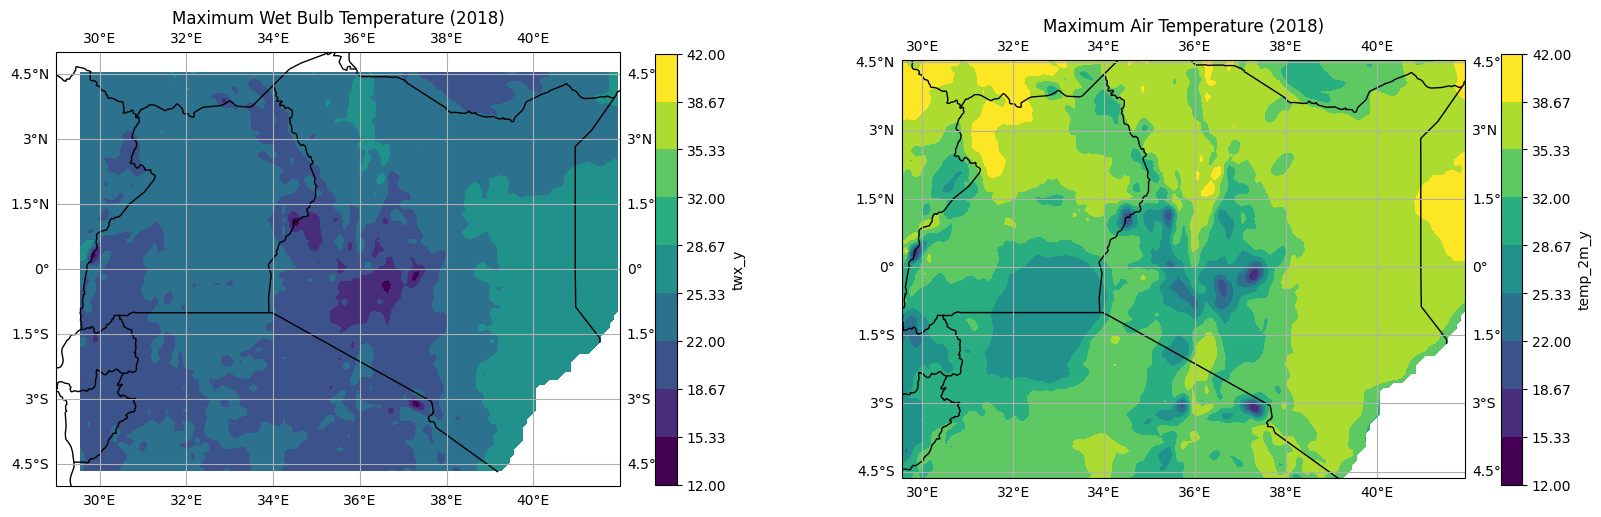

In [ ]:
# Extract twx_y and max_temp_2m data
twx_data = annual_max['twx_y']
temp_data = annual_max['temp_2m_y']

# Get the latitude and longitude coordinates
latitude = twx_data['lat']
longitude = twx_data['lon']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot twx_y data
p1 = twx_data.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),
                            levels=10, cmap='viridis', add_colorbar=True, vmin = 12, vmax = 42, cbar_kwargs={'shrink': 0.7})
ax1.add_feature(cfeature.BORDERS, edgecolor='black')
ax1.set_extent([29, 42, -5, 5], crs=ccrs.PlateCarree())
ax1.gridlines(draw_labels=True)
ax1.set_title('Maximum Wet Bulb Temperature (2018)')

# Plot max_temp_2m data
p2 = temp_data.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(),
                             levels=10, cmap='viridis', add_colorbar=True, vmin = 12, vmax = 42, cbar_kwargs={'shrink': 0.7})
ax2.add_feature(cfeature.BORDERS, edgecolor='black')
ax1.set_extent([29, 42, -5, 5], crs=ccrs.PlateCarree())
ax2.gridlines(draw_labels=True)
ax2.set_title('Maximum Air Temperature (2018)')

# Show the plot
plt.show()


# **Step 3 - Getting familiar with refugee data from UNHCR**

We'll read in and clip down some of our refugee data here, before setting up a geospatial extraction

---



In [ ]:
# load a shapefile of refugee camps from UNHCR
RefugeeCampsGeo = gpd.read_file('wrl_prp_p_unhcr_refugees_noLBN_onlySettlements-2024_02.geojson')
RefugeeCampsGeo # look at data

iso3       pcode     gis_name              name_alt adm1_pcode  \
0     UGA  UGAs990142    Kyangwali                  None   24UGA004   
1     NER  NERs009662    Kourdosso  Garin Yari Kourdosso   22NER004   
2     COG  COGs002937       Dongou                  None   20COG007   
3     ETH  ETHs028048      Tembien                  None   22ETH001   
4     PAK  PAKs006943     Kababian                  None   22PAK005   
...   ...         ...          ...                   ...        ...   
1339  COD  CODs006952  Bili Centre                  None   20COD503   
1340  COD  CODs006973       Limasa                  None   20COD405   
1341  COD  CODs006978        Mbito                  None   20COD503   
1342  COD  CODs006983       Nzeret                  None   20COD503   
1343  COD  CODs006990          Zee                  None   20COD503   

       adm2_pcode loc_type           loc_subtype pop_type hierarchy_pcode  \
0     24UGA004118      POC    Planned Settlement  Refugee  24UGA004118021   
1     22NER004005      POC  Spontaneous Location  Refugee  22NER004005524   
2     20COG007003      POC  Spontaneous Location  Refugee  20COG007003009   
3     22ETH001002      POC  Spontaneous Location  Refugee  22ETH001002010   
4     22PAK005028      POC    Planned Settlement  Refugee  22PAK005028013   
...           ...      ...                   ...      ...             ...   
1339  20COD503033      POC  Spontaneous Location  Refugee  20COD503033028   
1340  20COD405051      POC  Spontaneous Location  Refugee  20COD405051016   
1341  20COD503033      POC  Spontaneous Location  Refugee  20COD503033029   
1342  20COD503033      POC  Spontaneous Location  Refugee  20COD503033030   
1343  20COD503033      POC  Spontaneous Location  Refugee  20COD503033031   

                      footnote  source      lon      lat  \
0                         None   UNHCR  30.7636   1.1797   
1                               UNHCR    6.7415  13.5566   
2                  20COG007003  UNHCR   18.0560   2.0448   
3     Called settlement in ETH          39.0000  13.6164   
4              Refugee village  UNHCR   71.5333  34.0167   
...                        ...     ...      ...      ...   
1339                      None   UNHCR  25.1775   4.1508   
1340                      None   UNHCR  21.9543   4.2113   
1341                      None   UNHCR  24.9042   3.9869   
1342                      None   UNHCR  22.6928   4.2691   
1343                      None   UNHCR  24.9172   4.5408   

                       geometry  
0      POINT (30.76360 1.17970)  
1      POINT (6.74150 13.55660)  
2      POINT (18.05600 2.04480)  
3     POINT (39.00000 13.61640)  
4     POINT (71.53330 34.01670)  
...                         ...  
1339   POINT (25.17750 4.15080)  
1340   POINT (21.95430 4.21130)  
1341   POINT (24.90420 3.98690)  
1342   POINT (22.69280 4.26910)  
1343   POINT (24.91720 4.54080)  

[1344 rows x 15 columns]

In [ ]:
# for the purposes of this exercise, we'll focus on Uganda and Kenya
# filter the points based on whether they are in Africa
# load shapefiles of Africa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
uganda_kenya = world[(world['name'] == 'Uganda') | (world['name'] == 'Kenya')]

In [ ]:
# Use a spatial join to see whether these points are in our countries
PointsInUganda = gpd.sjoin(RefugeeCampsGeo, uganda_kenya, op='within')

# Filter the original DataFrame based on the index of points within Africa
RefugeeCampsGeoUganda = RefugeeCampsGeo.loc[PointsInUganda.index]
RefugeeCampsGeoUganda = RefugeeCampsGeoUganda.reset_index(drop=True)
RefugeeCampsGeoUganda = RefugeeCampsGeoUganda.drop(columns=['geometry'])
RefugeeCampsGeoUganda

iso3       pcode           gis_name name_alt adm1_pcode   adm2_pcode  \
0   UGA  UGAs990142          Kyangwali     None   24UGA004  24UGA004118   
1   UGA  UGAs990225             Lobule     None   24UGA003  24UGA003078   
2   UGA  UGAs001956              Oliji     None   24UGA003  24UGA003065   
3   UGA  UGAs004680            Mungula     None   24UGA003  24UGA003065   
4   UGA  UGAs004664           Nyumanzi     None   24UGA003  24UGA003065   
5   UGA  UGAs001958             Olua 2     None   24UGA003  24UGA003065   
6   UGA  UGAs032255            Palabek     None   24UGA003  24UGA003082   
7   UGA  UGAs002986           Kyaka II     None   24UGA004  24UGA004123   
8   UGA  UGAs001598            Mirieyi     None   24UGA003  24UGA003065   
9   UGA  UGAs001954           Baratuku     None   24UGA003  24UGA003065   
10  UGA  UGAs004662            Ayilo 1     None   24UGA003  24UGA003065   
11  UGA  UGAs990099              Rhino     None   24UGA003  24UGA003101   
12  UGA  UGAs004468          Rwamwanja     None   24UGA004  24UGA004113   
13  UGA  UGAs004661            Ayilo 2     None   24UGA003  24UGA003065   
14  UGA  UGAs002611           Maaji II     None   24UGA003  24UGA003065   
15  UGA  UGAs001953           Alere II     None   24UGA003  24UGA003065   
16  UGA  UGAs001836              Elema     None   24UGA003  24UGA003065   
17  UGA  UGAs004668  Imvepi Settlement     None   24UGA003  24UGA003101   
18  UGA  UGAs990102          Oruchinga     None   24UGA004  24UGA004108   
19  UGA  UGAs027216           Bidibidi     None   24UGA003  24UGA003099   
20  UGA  UGAs004663  Boroli Settlement     None   24UGA003  24UGA003065   
21  UGA  UGAs001852            Maaji I     None   24UGA003  24UGA003065   
22  UGA  UGAs001854          Mungula 2     None   24UGA003  24UGA003065   
23  UGA  UGAs004684           Pagrinya     None   24UGA003  24UGA003065   
24  UGA  UGAs002378        Kiryandongo     None   24UGA004  24UGA004120   
25  UGA  UGAs002612          Maaji III     None   24UGA003  24UGA003065   
26  UGA  UGAs990101          Palorinya     None   24UGA003  24UGA003093   
27  UGA  UGAs001945           Nakivale     None   24UGA004  24UGA004108   
28  UGA  UGAs001951              Agojo     None   24UGA003  24UGA003065   
29  UGA  UGAs001848             Olua 1     None   24UGA003  24UGA003065   
30  KEN  KENs009176          Kalobeyei     None   20KEN023  20KEN023124   
31  KEN  KENs001093             Kakuma     None   20KEN023  20KEN023124   
32  KEN  KENs001088          Dagahaley     None   20KEN007  20KEN007030   
33  KEN  KENs001091                Ifo     None   20KEN007  20KEN007030   
34  KEN  KENs001089           Hagadera     None   20KEN007  20KEN007031   

   loc_type         loc_subtype pop_type hierarchy_pcode     footnote  source  \
0       POC  Planned Settlement  Refugee  24UGA004118021         None   UNHCR   
1       POC  Planned Settlement  Refugee  24UGA003078009  RE-2013-SSD   UNHCR   
2       POC  Planned Settlement  Refugee  24UGA003065061  RE-2013-SSD   UNHCR   
3       POC  Planned Settlement  Refugee  24UGA003065047  RE-2013-SSD   UNHCR   
4       POC  Planned Settlement  Refugee  24UGA003065052         None   UNHCR   
5       POC  Planned Settlement  Refugee  24UGA003065063  RE-2013-SSD   UNHCR   
6       POC  Planned Settlement  Refugee  24UGA003082018         None   UNHCR   
7       POC  Planned Settlement  Refugee  24UGA004123007         None   UNHCR   
8       POC  Planned Settlement  Refugee  24UGA003065041  RE-2013-SSD   UNHCR   
9       POC  Planned Settlement  Refugee  24UGA003065014  RE-2013-SSD   UNHCR   
10      POC  Planned Settlement  Refugee  24UGA003065010  RE-2013-SSD   UNHCR   
11      POC  Planned Settlement  Refugee  24UGA003101028  RE-2013-SSD   UNHCR   
12      POC  Planned Settlement  Refugee  24UGA004113006         None   UNHCR   
13      POC  Planned Settlement  Refugee  24UGA003065011  RE-2013-SSD   UNHCR   
14      POC  Planned Settlement  Refugee  24UGA003065032  RE-2013-SSD   UNHCR   
15    

In [ ]:
# let's add these points to our map so we can see where the camps are and what the maximum temperature they were exposed to in 2019
myMap.add_points_from_xy(RefugeeCampsGeoUganda, x="lon", y="lat")
myMap.add_basemap('HYBRID')
myMap

Map(bottom=2132.0, center=[18.646245142670608, 36.74256478767337], controls=(WidgetControl(options=['position'…

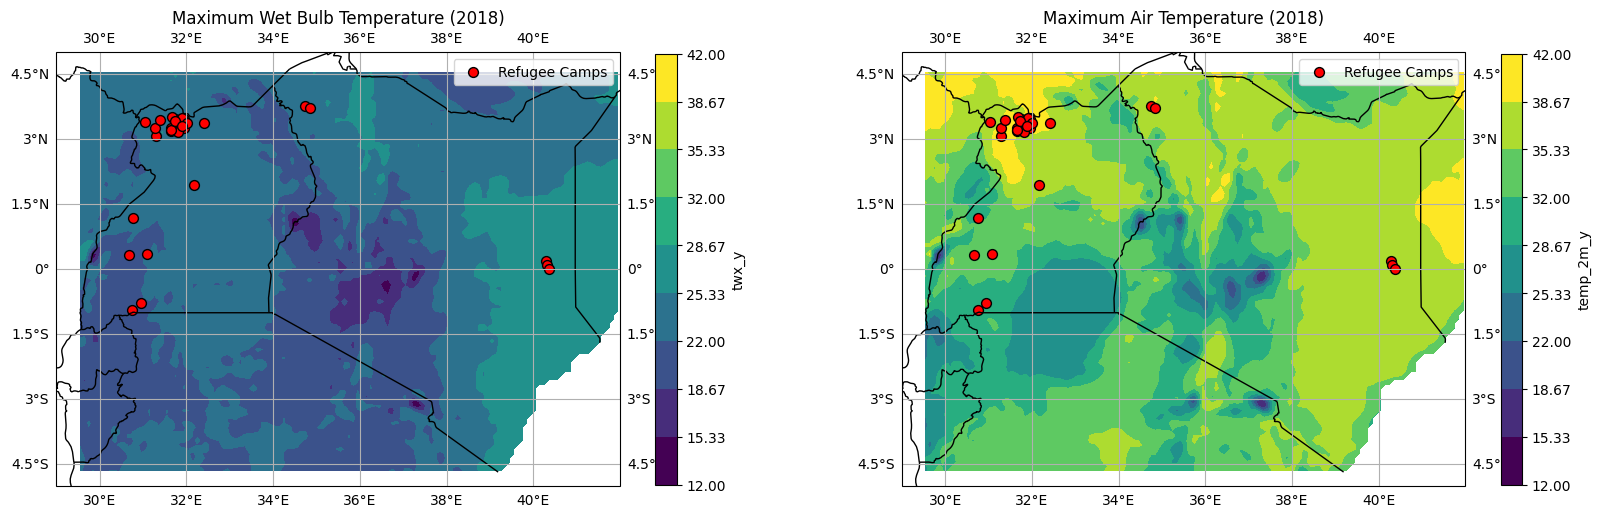

In [ ]:
# now lets plot them on our comparison maps so we can see what the variability in temperature might be
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract twx_y and max_temp_2m data
twx_data = annual_max['twx_y']
temp_data = annual_max['temp_2m_y']

# Get the latitude and longitude coordinates
latitude = twx_data['lat']
longitude = twx_data['lon']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot twx_y data
p1 = twx_data.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),
                            levels=10, cmap='viridis', add_colorbar=True, vmin = 12, vmax = 42, cbar_kwargs={'shrink': 0.7})
ax1.add_feature(cfeature.BORDERS, edgecolor='black')
ax1.set_extent([29, 42, -5, 5], crs=ccrs.PlateCarree())
ax1.gridlines(draw_labels=True)
ax1.set_title('Maximum Wet Bulb Temperature (2018)')

# Plot max_temp_2m data
p2 = temp_data.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(),
                             levels=10, cmap='viridis', add_colorbar=True, vmin = 12, vmax = 42, cbar_kwargs={'shrink': 0.7})
ax2.add_feature(cfeature.BORDERS, edgecolor='black')
ax2.set_extent([29, 42, -5, 5], crs=ccrs.PlateCarree())
ax2.gridlines(draw_labels=True)
ax2.set_title('Maximum Air Temperature (2018)')

# Plot points from RefugeeCampsGeoUganda on both maps
ax1.scatter(RefugeeCampsGeoUganda['lon'], RefugeeCampsGeoUganda['lat'], color='red', s=50, edgecolor='black', label='Refugee Camps')
ax2.scatter(RefugeeCampsGeoUganda['lon'], RefugeeCampsGeoUganda['lat'], color='red', s=50, edgecolor='black', label='Refugee Camps')

# Adding legends to both maps
ax1.legend()
ax2.legend()

# Show the plot
plt.show()


# **Step 4 - Setting up the geospatial extraction**

Now we have a sense of what the climate and refugee data look like. Now we want to extract the daily maximum temperature exposure for these camps for 2018.

We'll need to set up the data so we have a file that shows the daily maximum, and then extract it for the points

In [ ]:
# first, we'll calculate the daily maximum from our hourly data
daily_max = merged_hourly.resample(time='1D').max(dim = 'time').compute()
daily_max = daily_max.rename({'tw' : 'tw_dailymax'})
daily_max = daily_max.rename({'temperature_2m' : 't_2m_dailymax'})
daily_max # now we have the same lat/lon and only 365 time observations (i.e. the daily maximum)

<xarray.Dataset>
Dimensions:        (time: 364, lat: 93, lon: 125)
Coordinates:
  * lon            (lon) float64 29.55 29.65 29.75 29.85 ... 41.75 41.85 41.95
  * lat            (lat) float64 -4.65 -4.55 -4.45 -4.35 ... 4.25 4.35 4.45 4.55
  * time           (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-30
Data variables:
    t_2m_dailymax  (time, lat, lon) float32 22.54 21.27 21.2 ... 34.7 35.14
    tw_dailymax    (time, lat, lon) float64 19.49 18.0 17.84 ... 23.0 23.05
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [ ]:
# set latitude and longitude variables, as well as name for cluster ID
lat = RefugeeCampsGeoUganda['lat']
lon = RefugeeCampsGeoUganda['lon']
name = RefugeeCampsGeoUganda['pcode'] # this is a unique ID

In [ ]:
# for loop, loop through each lat/lon.pcode and extract the value from the climate data using the nearest approach
# concat these in to a new dataframe
RefugeeTempData = pd.DataFrame([])
dfs_to_concat = []

for i, j, k in zip(lat, lon, name):
    dsloc = daily_max.sel(lat=i, lon=j, method='nearest')
    DT = dsloc.to_dataframe()

    # Insert the name of the station with preferred column title:
    DT.insert(loc=0, column="pcode", value=k)
    dfs_to_concat.append(DT)

RefugeeTempData = pd.concat(dfs_to_concat, sort=True)
RefugeeTempData

lat    lon       pcode  t_2m_dailymax  tw_dailymax
time                                                           
2018-01-01  1.15  30.75  UGAs990142      28.016571    19.387502
2018-01-02  1.15  30.75  UGAs990142      27.817596    19.298006
2018-01-03  1.15  30.75  UGAs990142      28.199188    18.983188
2018-01-04  1.15  30.75  UGAs990142      28.241577    18.724189
2018-01-05  1.15  30.75  UGAs990142      29.020966    17.950934
...          ...    ...         ...            ...          ...
2018-12-26  0.05  40.35  KENs001089      36.464020    22.736783
2018-12-27  0.05  40.35  KENs001089      36.923157    22.849862
2018-12-28  0.05  40.35  KENs001089      36.735016    22.993880
2018-12-29  0.05  40.35  KENs001089      36.374512    23.774428
2018-12-30  0.05  40.35  KENs001089      35.571808    23.040795

[12740 rows x 5 columns]

In [ ]:
# make the dataframe time column and format correctly
RefugeeTempData.reset_index(inplace=True)

RefugeeTempData['time'] = pd.to_datetime(RefugeeTempData['time'])

# Format the time column to your desired format
RefugeeTempData['time'] = RefugeeTempData['time'].dt.strftime('%Y-%m-%d')
RefugeeTempData

time   lat    lon       pcode  t_2m_dailymax  tw_dailymax
0      2018-01-01  1.15  30.75  UGAs990142      28.016571    19.387502
1      2018-01-02  1.15  30.75  UGAs990142      27.817596    19.298006
2      2018-01-03  1.15  30.75  UGAs990142      28.199188    18.983188
3      2018-01-04  1.15  30.75  UGAs990142      28.241577    18.724189
4      2018-01-05  1.15  30.75  UGAs990142      29.020966    17.950934
...           ...   ...    ...         ...            ...          ...
12735  2018-12-26  0.05  40.35  KENs001089      36.464020    22.736783
12736  2018-12-27  0.05  40.35  KENs001089      36.923157    22.849862
12737  2018-12-28  0.05  40.35  KENs001089      36.735016    22.993880
12738  2018-12-29  0.05  40.35  KENs001089      36.374512    23.774428
12739  2018-12-30  0.05  40.35  KENs001089      35.571808    23.040795

[12740 rows x 6 columns]

In [ ]:
# We need to merge back in our original dataframe
RefugeeTempDataFinal = RefugeeTempData.drop(['lat', 'lon'], axis=1) # we are removing this because this is the lat/lon for the pixel, rather than the camp. We will add back in the camp lat/lon
RefugeeTempDataFinal = pd.merge(RefugeeTempDataFinal, RefugeeCampsGeoUganda, on='pcode', how='inner')
RefugeeTempDataFinal

time       pcode  t_2m_dailymax  tw_dailymax iso3   gis_name  \
0      2018-01-01  UGAs990142      28.016571    19.387502  UGA  Kyangwali   
1      2018-01-02  UGAs990142      27.817596    19.298006  UGA  Kyangwali   
2      2018-01-03  UGAs990142      28.199188    18.983188  UGA  Kyangwali   
3      2018-01-04  UGAs990142      28.241577    18.724189  UGA  Kyangwali   
4      2018-01-05  UGAs990142      29.020966    17.950934  UGA  Kyangwali   
...           ...         ...            ...          ...  ...        ...   
12735  2018-12-26  KENs001089      36.464020    22.736783  KEN   Hagadera   
12736  2018-12-27  KENs001089      36.923157    22.849862  KEN   Hagadera   
12737  2018-12-28  KENs001089      36.735016    22.993880  KEN   Hagadera   
12738  2018-12-29  KENs001089      36.374512    23.774428  KEN   Hagadera   
12739  2018-12-30  KENs001089      35.571808    23.040795  KEN   Hagadera   

      name_alt adm1_pcode   adm2_pcode loc_type         loc_subtype pop_type  \
0         None   24UGA004  24UGA004118      POC  Planned Settlement  Refugee   
1         None   24UGA004  24UGA004118      POC  Planned Settlement  Refugee   
2         None   24UGA004  24UGA004118      POC  Planned Settlement  Refugee   
3         None   24UGA004  24UGA004118      POC  Planned Settlement  Refugee   
4         None   24UGA004  24UGA004118      POC  Planned Settlement  Refugee   
...        ...        ...          ...      ...                 ...      ...   
12735     None   20KEN007  20KEN007031      POC  Planned Settlement  Refugee   
12736     None   20KEN007  20KEN007031      POC  Planned Settlement  Refugee   
12737     None   20KEN007  20KEN007031      POC  Planned Settlement  Refugee   
12738     None   20KEN007  20KEN007031      POC  Planned Settlement  Refugee   
12739     None   20KEN007  20KEN007031      POC  Planned Settlement  Refugee   

      hierarchy_pcode     footnote  source      lon     lat  
0      24UGA004118021         None   UNHCR  30.7636  1.1797  
1      24UGA004118021         None   UNHCR  30.7636  1.1797  
2      24UGA004118021         None   UNHCR  30.7636  1.1797  
3      24UGA004118021         None   UNHCR  30.7636  1.1797  
4      24UGA004118021         None   UNHCR  30.7636  1.1797  
...               ...          ...     ...      ...     ...  
12735  20KEN007031002  Dadaab area  UNHCR   40.3714  0.0053  
12736  20KEN007031002  Dadaab area  UNHCR   40.3714  0.0053  
12737  20KEN007031002  Dadaab area  UNHCR   40.3714  0.0053  
12738  20KEN007031002  Dadaab area  UNHCR   40.3714  0.0053  
12739  20KEN007031002  Dadaab area  UNHCR   40.3714  0.0053  

[12740 rows x 17 columns]

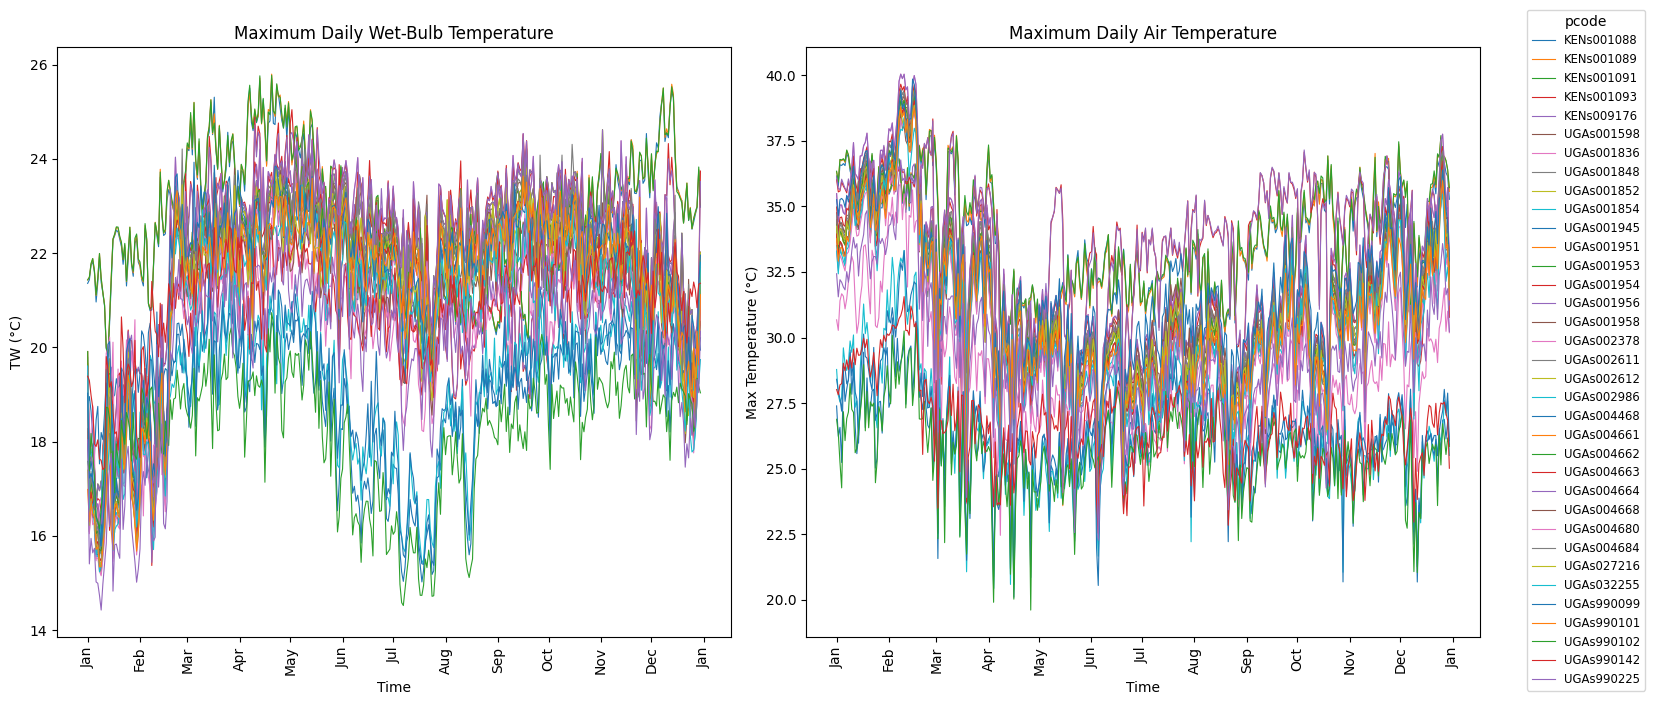

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define subplots with smaller size
fig, axs = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

# Plot 1: Mean 2m Air Temperature Over Time
# Group the data by 'pcode'
grouped_data = RefugeeTempDataFinal.groupby('pcode')

# Plot each group separately with different colors
for pcode, data in grouped_data:
    axs[0].plot(data['time'], data['tw_dailymax'], label=pcode, linewidth=0.8)

# Add labels and title
axs[0].set_xlabel('Time')
axs[0].set_ylabel('TW (°C)')
axs[0].set_title('Maximum Daily Wet-Bulb Temperature')

# Format x-axis to display only the month
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Set locator to show ticks for each month
axs[0].xaxis.set_major_locator(mdates.MonthLocator())

# Rotate x-axis labels by 90 degrees
axs[0].tick_params(axis='x', rotation=90)

# Plot 2: Max Daily Temperature Over Time
# Plot each group separately with different colors
for pcode, data in grouped_data:
    axs[1].plot(data['time'], data['t_2m_dailymax'], label=pcode, linewidth=0.8)

# Add labels and title
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Max Temperature (°C)')
axs[1].set_title('Maximum Daily Air Temperature')

# Format x-axis to display only the month
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Set locator to show ticks for each month
axs[1].xaxis.set_major_locator(mdates.MonthLocator())

# Rotate x-axis labels by 90 degrees
axs[1].tick_params(axis='x', rotation=90)

# Create a single legend outside of the plots, to the far right and smaller with additional padding
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='pcode', fontsize='small', bbox_to_anchor=(1.1, 1), borderaxespad=0.)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# for each camp, let's count the number of days in 2018 that exceeded a threshold
# let's set our threshold as 25 Tw
# Filtering the DataFrame where twx exceeds 25
FilteredData = RefugeeTempDataFinal[RefugeeTempDataFinal['tw_dailymax'] > 25]

# Counting the occurrences of each pcode
ThresholdCountData = FilteredData['pcode'].value_counts().reset_index()
ThresholdCountData # we can see that the camps in Kenya experience the most extreme heat.

pcode  count
0  KENs001089     22
1  KENs001091     20
2  KENs001088     18
3  KENs001093      1

# **Specific focus on one camp**

In [ ]:
# so let's focus on the hottest camp, KENs001089

hot_camp = RefugeeCampsGeoUganda[RefugeeCampsGeoUganda['pcode'] == 'KENs001089']
hot_camp # this is Hagadera camp, estimated to house over 100,000 people.

iso3       pcode  gis_name name_alt adm1_pcode   adm2_pcode loc_type  \
34  KEN  KENs001089  Hagadera     None   20KEN007  20KEN007031      POC   

           loc_subtype pop_type hierarchy_pcode     footnote  source      lon  \
34  Planned Settlement  Refugee  20KEN007031002  Dadaab area  UNHCR   40.3714   

       lat  
34  0.0053

In [ ]:
# get the latitude and longitude for the next step
point_lon_lat = (hot_camp['lon'].iloc[0], hot_camp['lat'].iloc[0])
point_lon_lat

(40.3714, 0.0053)

In [ ]:
dataset_hotcamp = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterDate(
    "2020-01-01", "2020-12-31"
)
ds_hotcamp = geemap.ee_to_xarray(dataset_hotcamp, crs="EPSG:4326", scale=0.1)
ds_hotcamp

<xarray.Dataset>
Dimensions:                                                       (time: 8760,
                                                                   lon: 3600,
                                                                   lat: 1800)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [ ]:
# Select the variables you need
selected_variables = ['temperature_2m', 'dewpoint_temperature_2m', 'surface_pressure']

# Extract data for the specified point
point_data_hotcamp = ds_hotcamp.sel(lon=point_lon_lat[0], lat=point_lon_lat[1], method='nearest')
point_data_hotcamp = point_data_hotcamp.drop_vars(set(point_data_hotcamp.data_vars) - set(selected_variables))
if 'lat' in point_data_hotcamp.coords:
    point_data_hotcamp = point_data_hotcamp.drop('lat')
if 'lon' in point_data_hotcamp.coords:
    point_data_hotcamp = point_data_hotcamp.drop('lon')
point_data_hotcamp

<xarray.Dataset>
Dimensions:                  (time: 8760)
Coordinates:
  * time                     (time) datetime64[ns] 2020-01-01 ... 2020-12-30T...
Data variables:
    dewpoint_temperature_2m  (time) float32 ...
    temperature_2m           (time) float32 ...
    surface_pressure         (time) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [ ]:
q_hotcamp = xr.apply_ufunc(moisture.specific_humidity_from_dewpoint_temperature, point_data_hotcamp.surface_pressure, point_data_hotcamp.dewpoint_temperature_2m).compute()
q_hotcamp = q_hotcamp.rename('q')
tw_hotcamp = xr.apply_ufunc(thermo.adiabatic_wet_bulb_temperature, point_data_hotcamp.surface_pressure, point_data_hotcamp.temperature_2m, q_hotcamp)
tw_hotcamp = tw_hotcamp - 273.15 # k to c
tw_hotcamp = tw_hotcamp.rename('tw')
tw_hotcamp

<xarray.DataArray 'tw' (time: 8760)>
array([21.90032716, 21.93124999, 21.87319912, ..., 23.51587683,
       23.25619935, 23.07966003])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-12-30T23:00:00

In [ ]:
tw_hotcamp_ds = tw_hotcamp.to_dataset()
tw_hotcamp_ds.attrs = dict(data = 'wet bulb temperature from ERA5', method='NEWT', unit = '°C')
tw_hotcamp_ds

<xarray.Dataset>
Dimensions:  (time: 8760)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-12-30T23:00:00
Data variables:
    tw       (time) float64 21.9 21.93 21.87 21.85 ... 23.91 23.52 23.26 23.08
Attributes:
    data:     wet bulb temperature from ERA5
    method:   NEWT
    unit:     °C

In [ ]:
# merge back in the 2m temperature
hotcamp_hourly = xr.merge([tw_hotcamp_ds, point_data_hotcamp])
hotcamp_hourly = hotcamp_hourly.drop_vars(['dewpoint_temperature_2m', 'surface_pressure'])
hotcamp_hourly['temperature_2m'] = hotcamp_hourly['temperature_2m'] - 273.15

hotcamp_hourly

<xarray.Dataset>
Dimensions:         (time: 8760)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01 ... 2020-12-30T23:00:00
Data variables:
    tw              (time) float64 21.9 21.93 21.87 21.85 ... 23.52 23.26 23.08
    temperature_2m  (time) float32 26.47 25.86 25.3 24.82 ... 25.12 25.16 25.18
Attributes:
    data:     wet bulb temperature from ERA5
    method:   NEWT
    unit:     °C

In [ ]:
# again, let's look at the daily maximum temperatures
hotcamp_daily_max = hotcamp_hourly.resample(time='1D').max(dim = 'time').compute()
hotcamp_daily_max = hotcamp_daily_max.rename({'tw' : 'tw_dailymax'})
hotcamp_daily_max = hotcamp_daily_max.rename({'temperature_2m' : 't_2m_dailymax'})
hotcamp_daily_max # now we have the same lat/lon and only 365 time observations (i.e. the daily maximum)


<xarray.Dataset>
Dimensions:        (time: 365)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-30
Data variables:
    tw_dailymax    (time) float64 24.0 23.69 24.63 23.52 ... 22.61 23.04 24.36
    t_2m_dailymax  (time) float32 36.15 36.91 35.97 36.57 ... 36.75 36.44 35.94
Attributes:
    data:     wet bulb temperature from ERA5
    method:   NEWT
    unit:     °C

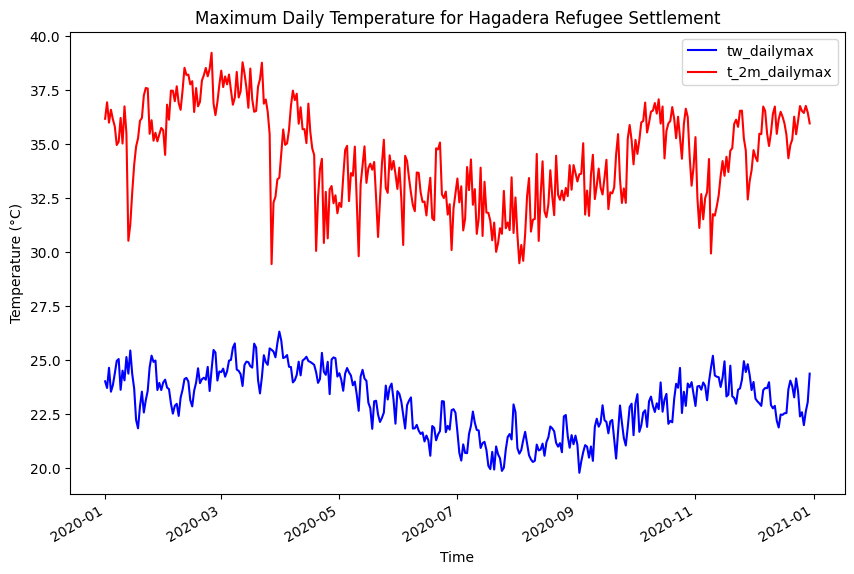

In [ ]:
import matplotlib.pyplot as plt
import xarray as xr

# Access the variables of interest
tw_dailymax = hotcamp_daily_max['tw_dailymax']
t_2m_dailymax = hotcamp_daily_max['t_2m_dailymax']

# Plot time versus tw_dailymax
plt.figure(figsize=(10, 6))
tw_dailymax.plot(label='tw_dailymax', color='blue')

# Plot time versus t_2m_dailymax
t_2m_dailymax.plot(label='t_2m_dailymax', color='red')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Maximum Daily Temperature for Hagadera Refugee Settlement')
plt.legend()

# Show plot
plt.show()


In [ ]:
# count the number of times threshold is exceeded
count_per_year = hotcamp_daily_max['tw_dailymax'].where(hotcamp_daily_max['tw_dailymax'] > 22).groupby('time.year').count(dim='time')
count_per_year_df = count_per_year.to_dataframe(name='count')
count_per_year_df

count
year       
2020    264

<Figure size 1000x600 with 0 Axes>

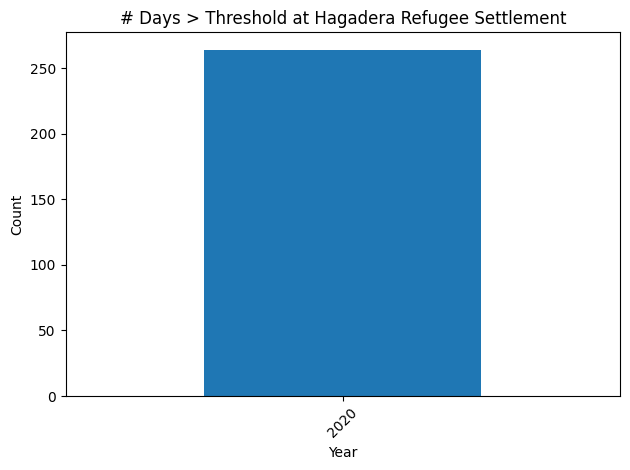

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
count_per_year_df.plot(kind='bar', legend=None)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('# Days > Threshold at Hagadera Refugee Settlement')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **With enough computational power, we can extract this for the whole record**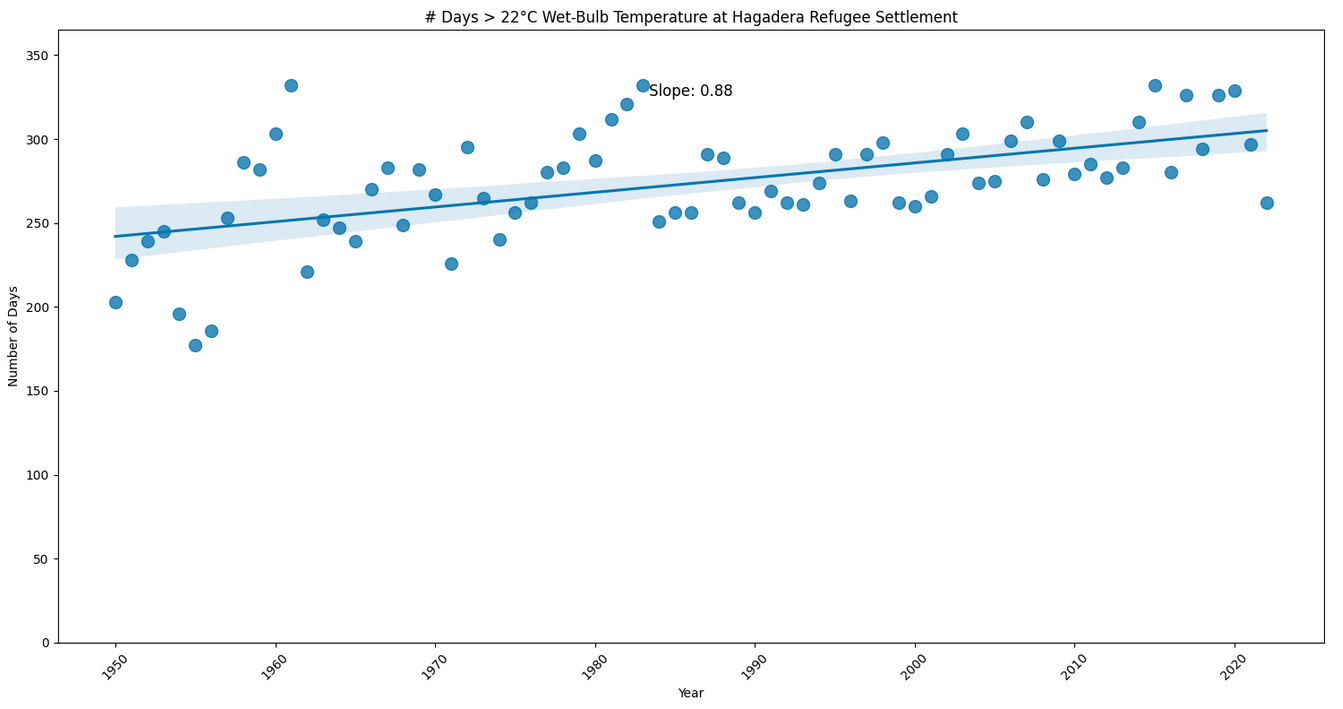

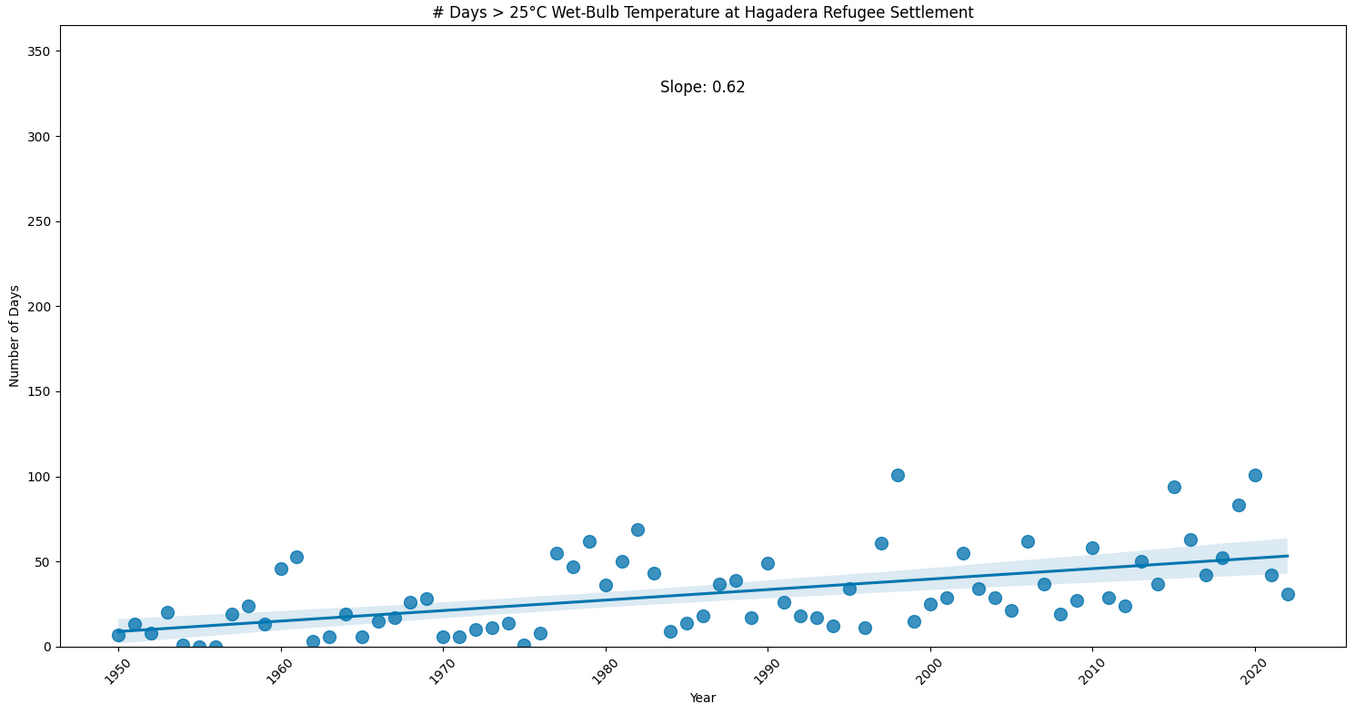